# 7.3 Creating a weak learner with a decision stump

In [18]:
import numpy as np

def loadSimpData():
    """
    生成一个简单的数据集
    :return: dataMat: 数据矩阵
             classLabels: 类别标签
    """
    dataMat = np.matrix([[1.0, 2.1],
                         [2.0, 1.1],
                         [1.3, 1.0],
                         [1.0, 1.0],
                         [2.0, 1.0]])
    classLabels = [1.0, 1.0, -1.0, -1.0, 1.0]
    return dataMat, classLabels

In [19]:
def stumpClassify(dataMatrix, dimen, threshVal, threshIneq):
    """
    单层决策树分类函数
    :param dataMatrix: 数据矩阵
    :param dimen: 特征维度
    :param threshVal: 阈值
    :param threshIneq: 不等式标志
    :return: retArray: 分类结果
    """
    retArray = np.ones((np.shape(dataMatrix)[0], 1))  # 初始化为1
    if threshIneq == 'lt':  # 小于阈值
        retArray[dataMatrix[:, dimen] <= threshVal] = -1.0
    else:  # 大于阈值
        retArray[dataMatrix[:, dimen] > threshVal] = -1.0
    return retArray

In [20]:
def buildStump(dataArr, classLabels, D):
    """
    构建单层决策树
    :param dataArr: 数据集
    :param classLabels: 类别标签
    :param D: 权重向量
    :return: bestStump: 最佳单层决策树
             minError: 最小错误率
             bestClassEst: 最佳分类结果
    """
    dataMatrix = np.mat(dataArr)  # 转换为矩阵
    labelMat = np.mat(classLabels).T  # 转置为列向量
    m, n = np.shape(dataMatrix)  # 获取数据集的行数和列数
    numSteps = 10.0  # 步长
    bestStump = {}  # 存储最佳单层决策树
    bestClassEst = np.mat(np.zeros((m, 1)))  # 初始化最佳分类结果
    minError = float('inf')  # 初始化最小错误率为无穷大

    for i in range(n):  # 遍历每个特征维度
        rangeMin = dataMatrix[:, i].min()  # 特征最小值
        rangeMax = dataMatrix[:, i].max()  # 特征最大值
        stepSize = (rangeMax - rangeMin) / numSteps  # 步长

        for j in range(-1, int(numSteps) + 1):  # 遍历每个阈值
            for inequal in ['lt', 'gt']:  # 遍历不等式标志
                threshVal = (rangeMin + float(j) * stepSize)  # 阈值计算
                predictedVals = stumpClassify(dataMatrix, i, threshVal, inequal)  # 分类结果

                errArr = np.mat(np.ones((m, 1)))  # 初始化错误矩阵为1
                errArr[predictedVals == labelMat] = 0  # 正确分类的标记为0
                weightedError = D.T * errArr  # 加权错误率

                if weightedError < minError:  # 如果当前错误率小于最小错误率，则更新最佳单层决策树和最小错误率
                    minError = weightedError
                    bestClassEst = predictedVals.copy()  # 更新最佳分类结果
                    bestStump['dim'] = i
                    bestStump['thresh'] = threshVal
                    bestStump['ineq'] = inequal
    return bestStump, minError, bestClassEst  # 返回最佳单层决策树、最小错误率和最佳分类结果

In [21]:
D = np.mat(np.ones((5, 1)) / 5)  # 初始化权重向量
dataArr, classLabels = loadSimpData()  # 加载数据集
bestStump, minError, bestClassEst = buildStump(dataArr, classLabels, D)  # 构建单层决策树
print("Best Stump:", bestStump)  # 打印最佳单层决策树
print("Minimum Error:", minError)  # 打印最小错误率
print("Best Class Estimation:", bestClassEst)  # 打印最佳分类结果

Best Stump: {'dim': 0, 'thresh': 1.3, 'ineq': 'lt'}
Minimum Error: [[0.2]]
Best Class Estimation: [[-1.]
 [ 1.]
 [-1.]
 [-1.]
 [ 1.]]


# 7.4 Implementing the full AdaBoost algorithm

In [22]:
def adaBoostTrainDS(dataArr, classLabels, numIt=40):
    """
    AdaBoost算法训练函数
    :param dataArr: 数据集
    :param classLabels: 类别标签
    :param numIt: 迭代次数
    :return: weakClassArr: 弱分类器数组
                aggClassEst: 加权分类结果
    """
    weakClassArr = []  # 初始化弱分类器数组
    m = np.shape(dataArr)[0]  # 获取数据集的行数
    D = np.mat(np.ones((m, 1)) / m)  # 初始化权重向量
    aggClassEst = np.mat(np.zeros((m, 1)))  # 初始化加权分类结果

    for i in range(numIt):  # 迭代训练弱分类器
        bestStump, error, classEst = buildStump(dataArr, classLabels, D)  # 构建单层决策树
        # print("D:", D.T)  # 打印当前权重向量
        
        alpha = float(0.5 * np.log((1.0 - error) / max(error, 1e-16)))  # 计算分类器权重

        bestStump['alpha'] = alpha  # 将权重添加到单层决策树中
        weakClassArr.append(bestStump)  # 添加到弱分类器数组中
        # print("Class Estimation:", classEst.T)  # 打印分类结果

        expon = np.multiply(-1 * alpha * np.mat(classLabels).T, classEst)  # 更新权重向量
        D = np.multiply(D, np.exp(expon))  # 更新权重向量
        D /= D.sum()  # 权重归一化

        aggClassEst += alpha * classEst  # 更新加权分类结果
        # print("Agg Class Estimation:", aggClassEst.T)  # 打印加权分类结果
        
        aggErrors = np.multiply(np.sign(aggClassEst) != np.mat(classLabels).T, np.ones((m, 1)))  # 计算错误率
        errorRate = aggErrors.sum() / m  # 计算错误率
        print("Total Error Rate:", errorRate)
        if errorRate == 0.0:
            print("Perfect classification achieved!")
            break   

    return weakClassArr,aggClassEst # 返回弱分类器数组,加权分类结果

In [23]:
classifyArr,_ = adaBoostTrainDS(dataArr, classLabels, 9)  # 训练AdaBoost分类器
print("Weak Classifiers:", classifyArr)  # 打印弱分类器数组

Total Error Rate: 0.2
Total Error Rate: 0.2
Total Error Rate: 0.0
Perfect classification achieved!
Weak Classifiers: [{'dim': 0, 'thresh': 1.3, 'ineq': 'lt', 'alpha': 0.6931471805599453}, {'dim': 1, 'thresh': 1.0, 'ineq': 'lt', 'alpha': 0.9729550745276565}, {'dim': 0, 'thresh': 0.9, 'ineq': 'lt', 'alpha': 0.8958797346140273}]


# 7.5 Test: classifying with AdaBoost

In [24]:
def adaClassify(dataToClass, classifierArr):
    """
    AdaBoost分类函数
    :param dataToClass: 待分类数据
    :param classifierArr: 弱分类器数组
    :return: 分类结果
    """
    dataMatrix = np.mat(dataToClass)  # 转换为矩阵
    m = np.shape(dataMatrix)[0]  # 获取数据集的行数
    aggClassEst = np.mat(np.zeros((m, 1)))  # 初始化加权分类结果

    for i in range(len(classifierArr)):  # 遍历每个弱分类器
        classEst = stumpClassify(dataMatrix, classifierArr[i]['dim'], classifierArr[i]['thresh'], classifierArr[i]['ineq'])  # 分类结果
        aggClassEst += classifierArr[i]['alpha'] * classEst  # 更新加权分类结果
        print("aggClassEst:", aggClassEst.T)  # 打印加权分类结果
    return np.sign(aggClassEst)  # 返回最终分类结果

In [25]:
print("Classify Result:", adaClassify([0, 0], classifyArr))  # 打印分类结果

aggClassEst: [[-0.69314718]]
aggClassEst: [[-1.66610226]]
aggClassEst: [[-2.56198199]]
Classify Result: [[-1.]]


# 7.6 Example: AdaBoost on a difficult dataset

In [26]:
def loadDataSet(fileName):
    """
    加载数据集
    :param fileName: 文件名
    :return: dataMat: 数据矩阵
             labelMat: 类别标签
    """
    dataMat = []  # 初始化数据矩阵
    labelMat = []  # 初始化类别标签
    numFeat = len(open(fileName).readline().split('\t'))  # 获取特征数量
    with open(fileName) as fr:  # 打开文件
        for line in fr.readlines():  # 遍历每一行
            lineArr = []
            curLine = line.strip().split('\t')  # 去除空格和换行符，并按制表符分割
            for i in range(numFeat - 1):  # 遍历特征
                lineArr.append(float(curLine[i]))  # 添加特征值
            dataMat.append(lineArr)  # 添加到数据矩阵
            labelMat.append(float(curLine[-1]))  # 添加到类别标签
    return dataMat, labelMat  # 返回数据矩阵和类别标签

In [28]:
dataArr, labelArr = loadDataSet('horseColicTraining2.txt')  # 加载数据集
classifierArr,_ = adaBoostTrainDS(dataArr, labelArr, 10)  # 训练AdaBoost分类器
testArr, testLabelArr = loadDataSet('horseColicTest2.txt')  # 加载测试数据集
prediction10 = adaClassify(testArr, classifierArr)  # 进行分类
errArr = np.mat(np.ones((67, 1)))  # 初始化错误矩阵
print("Error Count:", errArr[prediction10 != np.mat(testLabelArr).T].sum() / 67.0)  # 打印错误数量

Total Error Rate: 0.2842809364548495
Total Error Rate: 0.2842809364548495
Total Error Rate: 0.24749163879598662
Total Error Rate: 0.24749163879598662
Total Error Rate: 0.25418060200668896
Total Error Rate: 0.2408026755852843
Total Error Rate: 0.2408026755852843
Total Error Rate: 0.22073578595317725
Total Error Rate: 0.24749163879598662
Total Error Rate: 0.23076923076923078
aggClassEst: [[ 0.46166238  0.46166238 -0.46166238 -0.46166238  0.46166238  0.46166238
   0.46166238  0.46166238  0.46166238  0.46166238  0.46166238 -0.46166238
  -0.46166238  0.46166238  0.46166238  0.46166238  0.46166238 -0.46166238
  -0.46166238 -0.46166238 -0.46166238  0.46166238 -0.46166238 -0.46166238
   0.46166238  0.46166238  0.46166238  0.46166238  0.46166238  0.46166238
   0.46166238  0.46166238 -0.46166238  0.46166238  0.46166238  0.46166238
   0.46166238  0.46166238  0.46166238  0.46166238  0.46166238  0.46166238
   0.46166238  0.46166238  0.46166238  0.46166238 -0.46166238  0.46166238
  -0.46166238  0.46

# 7.7 Classification imbalance

### 7.7.1 ROC

In [29]:
import matplotlib.pyplot as plt

def plotROC(predStrengths, classLabels):
    cur = (1.0, 1.0)  # 初始化曲线坐标
    ySum = 0.0  # 初始化y坐标和
    numPosClas = sum(np.array(classLabels) == 1.0)  # 正类数量
    yStep = 1.0 / numPosClas  # y坐标步长
    xStep = 1.0 / (len(classLabels) - numPosClas)  # x坐标步长
    sortedIndicies = predStrengths.argsort()  # 排序索引
    fig = plt.figure()  # 创建图形
    ax = fig.add_subplot(111)  # 添加子图
    for index in sortedIndicies.tolist()[0]:  # 遍历排序索引
        if classLabels[index] == 1.0:  # 正类
            delX = 0  # x坐标增量
            delY = yStep  # y坐标增量
        else:  # 负类
            delX = xStep  # x坐标增量
            delY = 0  # y坐标增量
            ySum += cur[1]  # 更新y坐标和
        ax.plot([cur[0], cur[0] - delX], [cur[1], cur[1] - delY], c='b')  # 绘制曲线
        cur = (cur[0] - delX, cur[1] - delY)  # 更新曲线坐标
    ax.plot([0, 1], [0, 1], 'b--')  # 绘制对角线
    plt.xlabel('False Positive Rate')  # x轴标签
    plt.ylabel('True Positive Rate')  # y轴标签
    plt.title('ROC Curve')  # 图形标题
    ax.axis([0, 1, 0, 1])  # 设置坐标轴范围
    plt.show()  # 显示图形
    print("the Area under the curve is:", ySum * xStep)  # 打印曲线下面积
    

Total Error Rate: 0.2842809364548495
Total Error Rate: 0.2842809364548495
Total Error Rate: 0.24749163879598662
Total Error Rate: 0.24749163879598662
Total Error Rate: 0.25418060200668896
Total Error Rate: 0.2408026755852843
Total Error Rate: 0.2408026755852843
Total Error Rate: 0.22073578595317725
Total Error Rate: 0.24749163879598662
Total Error Rate: 0.23076923076923078
Total Error Rate: 0.2408026755852843
Total Error Rate: 0.2140468227424749
Total Error Rate: 0.22742474916387959
Total Error Rate: 0.21739130434782608
Total Error Rate: 0.22073578595317725
Total Error Rate: 0.21739130434782608
Total Error Rate: 0.22408026755852842
Total Error Rate: 0.22408026755852842
Total Error Rate: 0.23076923076923078
Total Error Rate: 0.22408026755852842
Total Error Rate: 0.2140468227424749
Total Error Rate: 0.20735785953177258
Total Error Rate: 0.22408026755852842
Total Error Rate: 0.22408026755852842
Total Error Rate: 0.2140468227424749
Total Error Rate: 0.22073578595317725
Total Error Rate: 0.

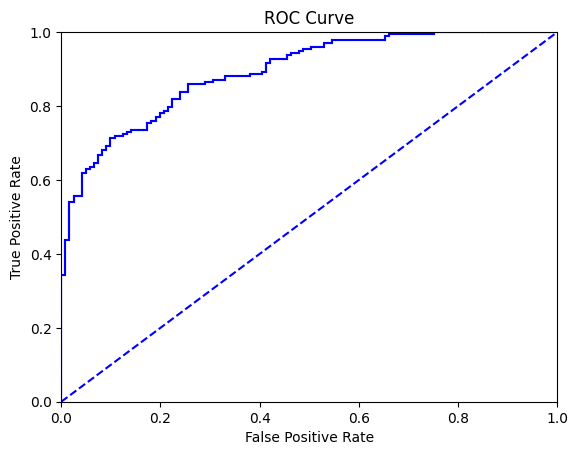

the Area under the curve is: 0.8918191104095092


In [31]:
dataArr, labelArr = loadDataSet('horseColicTraining2.txt')  # 加载数据集
classifierArr,aggClassEst = adaBoostTrainDS(dataArr, labelArr, 40)  # 训练AdaBoost分类器
plotROC(aggClassEst.T, labelArr)  # 绘制ROC曲线